In [1]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

#Plotly Libraris
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import plotly.io as pio



warnings.filterwarnings('ignore')

pio.templates.default = "ggplot2"

#dataframe display settings
pd.set_option('display.max_columns', 5000000)
pd.set_option('display.max_rows', 50000000)

c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [18]:
## Data from dataset 3
industry_trends = pd.read_csv('data/dataset3.csv')
industry_trends.rename(columns={"Unnamed: 0": "StartupID", "Unnamed: 6": "City_ZIP"}, inplace=True)
## Data from dataset 4
startup_info = pd.read_csv('data/dataset4.csv')


In [30]:
startup_info['founded_year'] = pd.to_datetime(startup_info['founded_at'], errors = 'coerce').dt.year
startup_info['funding_total_usd'].replace('-', 0, inplace=True)
startup_info['funding_total_usd'] = startup_info['funding_total_usd'].astype(float)
startup_info = startup_info.drop_duplicates()

# Cleanning dataset
clean_startup_info = startup_info.drop(['permalink', 'homepage_url'], axis=1)

# Remove the NaN name
clean_startup_info.dropna(how='any', subset=['name'], axis=0, inplace=True)
# Treat Nan category

clean_startup_info['category_list'] = clean_startup_info['category_list'].replace(np.nan, 'other')

# Convert 'first_funding_at' column to datetime and extract year
clean_startup_info['first_funding_year'] = clean_startup_info.first_funding_at.str.split("-").str[0]
clean_startup_info['first_funding_year'] = clean_startup_info['first_funding_year'].astype(float)

clean_startup_info['funding_total_usd'] = clean_startup_info['funding_total_usd'].replace('-', np.nan)


# Drop rows with 'first_funding_year' < 1749
clean_startup_info.drop(clean_startup_info[clean_startup_info['first_funding_year'] < 1749].index, inplace=True)
clean_startup_info.drop(clean_startup_info[clean_startup_info['first_funding_year'] > 2024].index, inplace=True)

# Convert 'founded_at', 'first_funding_at', and 'last_funding_at' columns to datetime
clean_startup_info['founded_at'] = pd.to_datetime(clean_startup_info['founded_at'], errors='coerce')
clean_startup_info['first_funding_at'] = pd.to_datetime(clean_startup_info['first_funding_at'])
clean_startup_info['last_funding_at'] = pd.to_datetime(clean_startup_info['last_funding_at'])

# Fill NaN values in 'founded_at' column with values from 'first_funding_at' column
clean_startup_info['founded_at'].fillna(clean_startup_info['first_funding_at'], inplace=True)

# Convert datetime values to ordinal, handling NaT values
clean_startup_info['founded_at'] = clean_startup_info['founded_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)
clean_startup_info['first_funding_at'] = clean_startup_info['first_funding_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)
clean_startup_info['last_funding_at'] = clean_startup_info['last_funding_at'].apply(lambda x: x.toordinal() if not pd.isnull(x) else 0)
clean_startup_info.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_year,first_funding_year
0,#fame,Media,10000000.0,operating,IND,16,Mumbai,Mumbai,1,735603,735603,735603,NaN,2015.0
1,:Qounter,Application Platforms|Real Time|Social Network...,700000.0,operating,USA,DE,DE - Other,Delaware City,2,735480,735293,735520,2014.0,2014.0
2,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,3406878.0,operating,NaN,NaN,NaN,NaN,1,735263,735263,735263,NaN,2014.0
3,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,732677,733120,733120,2007.0,2008.0
4,004 Technologies,Software,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,733773,735438,735438,2010.0,2014.0


In [31]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# Initialize KNNImputer for numerical features
numerical_imputer = KNNImputer(n_neighbors=5)

# Initialize SimpleImputer for categorical features (impute with mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Define numerical and categorical columns
numerical_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'funding_total_usd'] 
categorical_columns = ['category_list', 'city', 'state_code']  

# Impute missing values for numerical columns using KNNImputer
clean_startup_info[numerical_columns] = numerical_imputer.fit_transform(clean_startup_info[numerical_columns])

# Impute missing values for categorical columns using SimpleImputer
clean_startup_info[categorical_columns] = categorical_imputer.fit_transform(clean_startup_info[categorical_columns])

# Ensure category_list is converted back to string after imputation
clean_startup_info['category_list'] = clean_startup_info['category_list'].astype(str)

# Convert the category_list column into a list of categories
clean_startup_info['category_list'] = clean_startup_info['category_list'].str.split('|')

# Select the most repeated category for each company
clean_startup_info['category_code'] = clean_startup_info['category_list'].apply(lambda x: max(set(x), key=x.count))
clean_startup_info['category_code'] = clean_startup_info['category_code'].apply(lambda x: x.lower())
clean_startup_info.head()


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_year,first_funding_year,category_code
0,#fame,[Media],10000000.0,operating,IND,16,Mumbai,Mumbai,1,735603.0,735603.0,735603.0,NaN,2015.0,media
1,:Qounter,"[Application Platforms, Real Time, Social Netw...",700000.0,operating,USA,DE,DE - Other,Delaware City,2,735480.0,735293.0,735520.0,2014.0,2014.0,application platforms
2,"(THE) ONE of THEM,Inc.","[Apps, Games, Mobile]",3406878.0,operating,NaN,CA,NaN,San Francisco,1,735263.0,735263.0,735263.0,NaN,2014.0,games
3,0-6.com,[Curated Web],2000000.0,operating,CHN,22,Beijing,Beijing,1,732677.0,733120.0,733120.0,2007.0,2008.0,curated web
4,004 Technologies,[Software],0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,733773.0,735438.0,735438.0,2010.0,2014.0,software


In [32]:
from sklearn.preprocessing import OrdinalEncoder

state_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
city_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
category_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
status_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

clean_startup_info['state_code'] = state_encoder.fit_transform(clean_startup_info['state_code'].values.reshape(-1, 1))
clean_startup_info['city'] = city_encoder.fit_transform(clean_startup_info['city'].values.reshape(-1, 1))
clean_startup_info['category_code'] = category_encoder.fit_transform(clean_startup_info['category_code'].values.reshape(-1, 1))
clean_startup_info['status'] = status_encoder.fit_transform(clean_startup_info['status'].values.reshape(-1, 1))




In [36]:
clean_startup_info['labels'] = np.where(clean_startup_info['status'] == 'acquired', 1, 0)
clean_startup_info['funding_total_usd'] = clean_startup_info['funding_total_usd'].astype(float)

columns_processed = ['state_code', 'city', 'founded_at',
                     'first_funding_at', 'last_funding_at', 'funding_rounds',
                     'funding_total_usd', 'category_code', 'status',
                     'labels']
correlation_df = clean_startup_info[columns_processed].head()

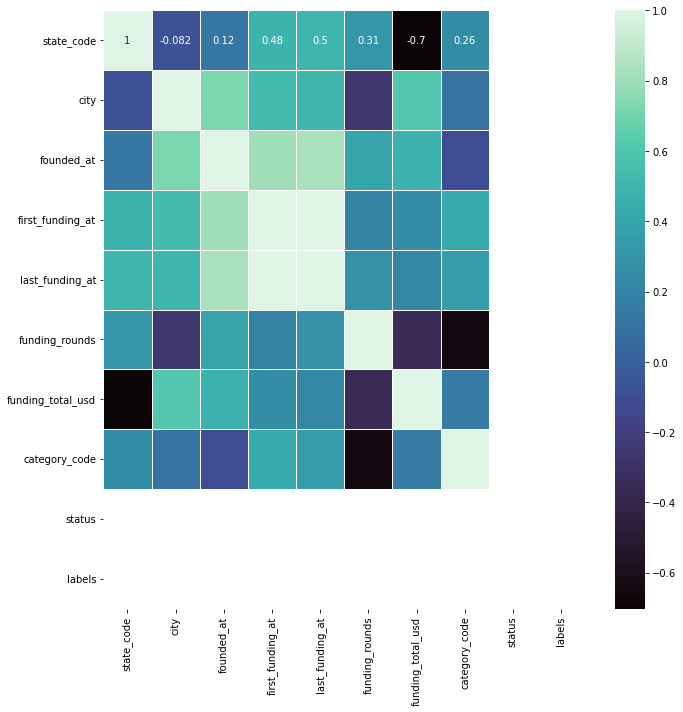

In [37]:
correlation = correlation_df.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

ValueError: setting an array element with a sequence.

NameError: name 'correlation_df' is not defined